<a href="https://colab.research.google.com/github/segravjf/python_practice/blob/main/predict_missing_appointments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting missing appointments

The following [dataset](https://raw.githubusercontent.com/erood/interviewqs.com_code_snippets/master/Datasets/medical_no_show.csv) has records on patients showing up for their appointments. There is also some lightweight medical data and appointment notification data. More information about the schema can be found here.


    

Given the following data can you create a Random Forest model to predict if a patient is a "no-show"? Can you also create a list of features sorted on their gini importance? You can read about gini importance here.

In [1]:
## Let's import some key modules
!pip install shap
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 15.7 MB/s eta 0:00:00


In [2]:
## Import data
df = pd.read_csv('https://raw.githubusercontent.com/erood/interviewqs.com_code_snippets/master/Datasets/medical_no_show.csv')

df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
len(df)

110527

In [4]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

In [5]:
## Convert the target variable to Boolean
df['no_show'] = 1
df.loc[df['No-show'] == 'No' ,'no_show'] = 0

df.groupby(['no_show']).count()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
no_show,,,,,,,,,,,,,,
0,88208,88208,88208,88208,88208,88208,88208,88208,88208,88208,88208,88208,88208,88208
1,22319,22319,22319,22319,22319,22319,22319,22319,22319,22319,22319,22319,22319,22319


In [6]:
## Quick glance at neighbourhood
df.groupby(['Neighbourhood'])['no_show'].count(
)

Neighbourhood
AEROPORTO                 8
ANDORINHAS             2262
ANTÔNIO HONÓRIO         271
ARIOVALDO FAVALESSA     282
BARRO VERMELHO          423
                       ... 
SÃO JOSÉ               1977
SÃO PEDRO              2448
TABUAZEIRO             3132
UNIVERSITÁRIO           152
VILA RUBIM              851
Name: no_show, Length: 81, dtype: int64

> Overall, looks like too many neighborhoods to do much with at this point. I could probably do a deeper analysis on top neighborhoods with no shows or distance between neighborhoods and the location, but that isn't the point of this exercise so much as model evaluation on the other side.

In [7]:
## Create a dummy for sex
dummies = pd.get_dummies(df['Gender']).rename(columns=lambda x: 'Category_' + str(x))
df = pd.concat([df, dummies], axis=1)

df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,no_show,Category_F,Category_M
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,1,0
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,0,1
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,1,0
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,1,0
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,1,0


In [8]:
## Set up the train/test
X = df[['Category_F','Age','Scholarship','Hipertension','Diabetes','Alcoholism','Handcap','SMS_received']]
y = df[['no_show']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1738)

print(len(y_train))
print(len(y_test))

88421
22106


In [9]:
## Fit a RF classifier with 100 Decision Trees
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier()

In [10]:
## Apply to test
pred = rf.predict(X_test)

pred

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
## Assess model fit
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.99      0.88     17651
           1       0.31      0.02      0.03      4455

    accuracy                           0.79     22106
   macro avg       0.55      0.50      0.46     22106
weighted avg       0.70      0.79      0.71     22106



In [12]:
print(confusion_matrix(y_test, pred))

[[17485   166]
 [ 4382    73]]


In [13]:
## Look at the basic feature importance
rf.feature_importances_

array([0.02138251, 0.69872335, 0.01644519, 0.01879925, 0.01439992,
       0.01642337, 0.02422909, 0.18959733])

<Axes: xlabel='importance', ylabel='column'>

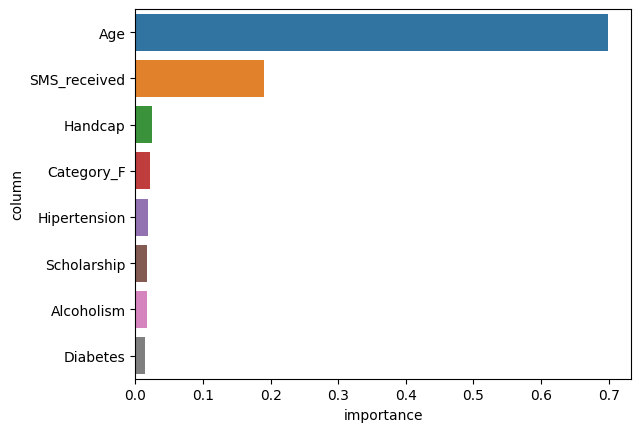

In [14]:
## Prettier plot w feature importances
import seaborn as sns
fi = pd.DataFrame({
    'importance': rf.feature_importances_,
    'column': X.columns
})

fi_sorted = fi.sort_values(by='importance',ascending = False)
sns.barplot(x='importance',y='column',data=fi_sorted)

In [15]:
## Also look at permutation importance in addition to Gini
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf, X_test, y_test, random_state = 1738)

<Axes: xlabel='permutation_importance', ylabel='columns'>

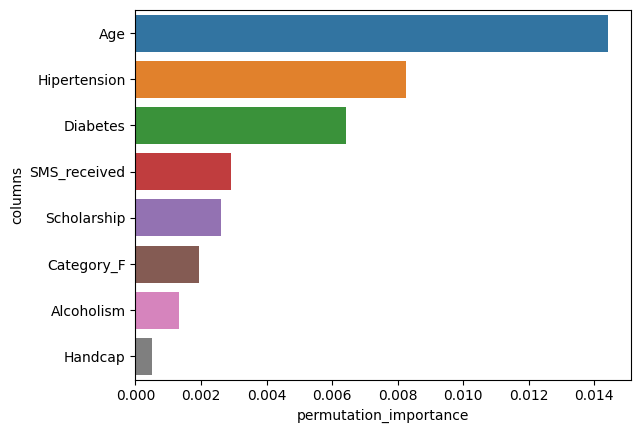

In [16]:
pi = pd.DataFrame({
    'permutation_importance': perm_importance.importances_mean,
    'columns': X.columns
})

pi_sorted = pi.sort_values(by='permutation_importance', ascending = False)

sns.barplot(x='permutation_importance',y='columns', data=pi_sorted)

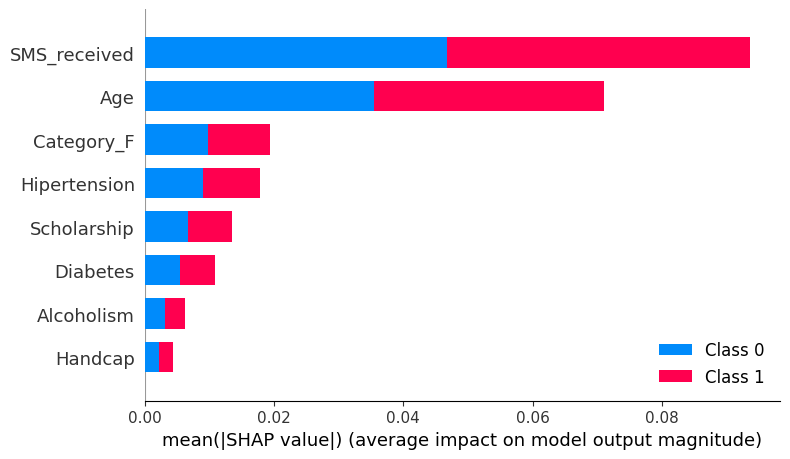

In [17]:
## Now look at Shap values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")